<div style='background-image: url("title01.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 200px'>
<div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computers, Waves, Simulations</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">1D Elastic Wave Equation - Staggered Grid Finite Difference</div>
        </div>
    </div>
</div>

This exercise covers the following aspects:

* Solving velocity-stress formulation of 1D wave equation with finite difference method
* Understanding the grid-staggering in connection with finite difference solution to the elastic wave equation
---

## Basic Equations

The 1D wave equation (velocity-stress formulation) as a coupled system of two first-order partial differential equations

$$
\rho \partial_t v = \partial_x \sigma + f 
$$
$$
\partial_t \sigma = \mu \partial_x v 
$$

where, $ \sigma $ is the stress, $ \rho $ is the density, $ v $ is the velocity, $ \mu $ is the shear modulus, and $ f $ is the source.

Grid staggering is the concept in connection with finite-difference solutions to the elastic wave equation. 
The discrete velocity and stress are defined on a regular spaced grid in space and time. Then, partial derivatives are replaced with centered finite-difference approximations to first derivative. However, these are not defined at the grid points of a function but in-between the grid points.
In grid staggering, the following computational scheme is used

$$
\frac{v_i^{j+ \tfrac{1}{2}} - v_i^{j- \tfrac{1}{2}} }{dt} \ = \ \frac{1}{\rho_i}\frac{\sigma_{i + \tfrac{1}{2}}^j - \sigma_{i - \tfrac{1}{2}}^j }{dx} + \frac{f_i^j}{\rho_i} \
$$

$$
\frac{\sigma_{i+\tfrac{1}{2}}^{j+1} - \sigma_{i+\tfrac{1}{2}}^j }{dt} \ = \ \mu_{i+\tfrac{1}{2}}  \frac{v_{i + 1}^{j +\tfrac{1}{2}} - v_i^{j + \tfrac{1}{2}} }{dx}
$$

The extrapolation scheme becomes

$$
v_i^{j+ \tfrac{1}{2}} \ = \ \frac{dt}{\rho_i} \frac{\sigma_{i + \tfrac{1}{2}}^j - \sigma_{i - \tfrac{1}{2}}^j }{dx} \ + \ v_i^{j- \tfrac{1}{2}}  + \frac{dt}{\rho_i} \ f_i^j  \
$$

$$
\sigma_{i+\tfrac{1}{2}}^{j+1} \ = \ dt \ \mu_{i+\tfrac{1}{2}} \frac{v_{i + 1}^{j +\tfrac{1}{2}} - v_i^{j + \tfrac{1}{2}} }{dx} \ + \ \sigma_{i+\tfrac{1}{2}}^j  \ \
$$


**Note that in the code below we do not deal with the index fractions.**

In [15]:
# Import libraries (Please run it before the simulation code!)

import numpy as np
import matplotlib
# Show Plot in The Notebook
matplotlib.use("nbagg")
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.facecolor'] = 'w'          # remove grey background


In [16]:
# Initialization of parameters

# Simple finite difference solver
# Elastic wave equation
# 1-D regular staggered grid

# Basic parameters
nt = 1300                                              # number of time steps
nx = 1000                                              # number of grid points in x
c0 = 4500                                              # velocity (m/sec) (shear wave)
eps = 0.8                                              # CFL stability limit
isnap = 2                                              # snapshot frequency
isx = round(nx/2)                                      # source location
f0 = 0.1                                               # frequency (Hz)
xmax = 1000000.                                        # maximum range (m)
rho0 = 2500.                                           # density (kg/m**3)
mu0 = rho0*c0**2.                                      # shear modulus (Pa)
nop = 4                                                # number of operator either 2 or 4

dx = xmax / (nx-1)                                     # calculate space increment (m)
x = (np.arange(nx) * dx)                               # initialize space coordinates 
dt = eps * dx/c0                                       # calculate time step from stability criterion(s)

# Source time function
# t = (np.arange(0, nt) * dt)                            # initialize time axis
T0 = 1. / f0                                           # period (s)
a = 4. / T0                                            # half-width 
t0 = T0 / dt
tmp = np.zeros(nt)
for it in range(nt):
    t = (it - t0) * dt
    tmp[it] = -2 * a * t * np.exp(-(a * t) ** 2)       # derivative of Gaussian 
src = np.zeros(nt)                                     # source
src[0:len(tmp)] = tmp
lam = c0 * T0                                          # wavelength


rho = 2500.0 , f_dom = 0.1 , stability limit = 0.8 , n_lambda 44.955


<IPython.core.display.Javascript object>


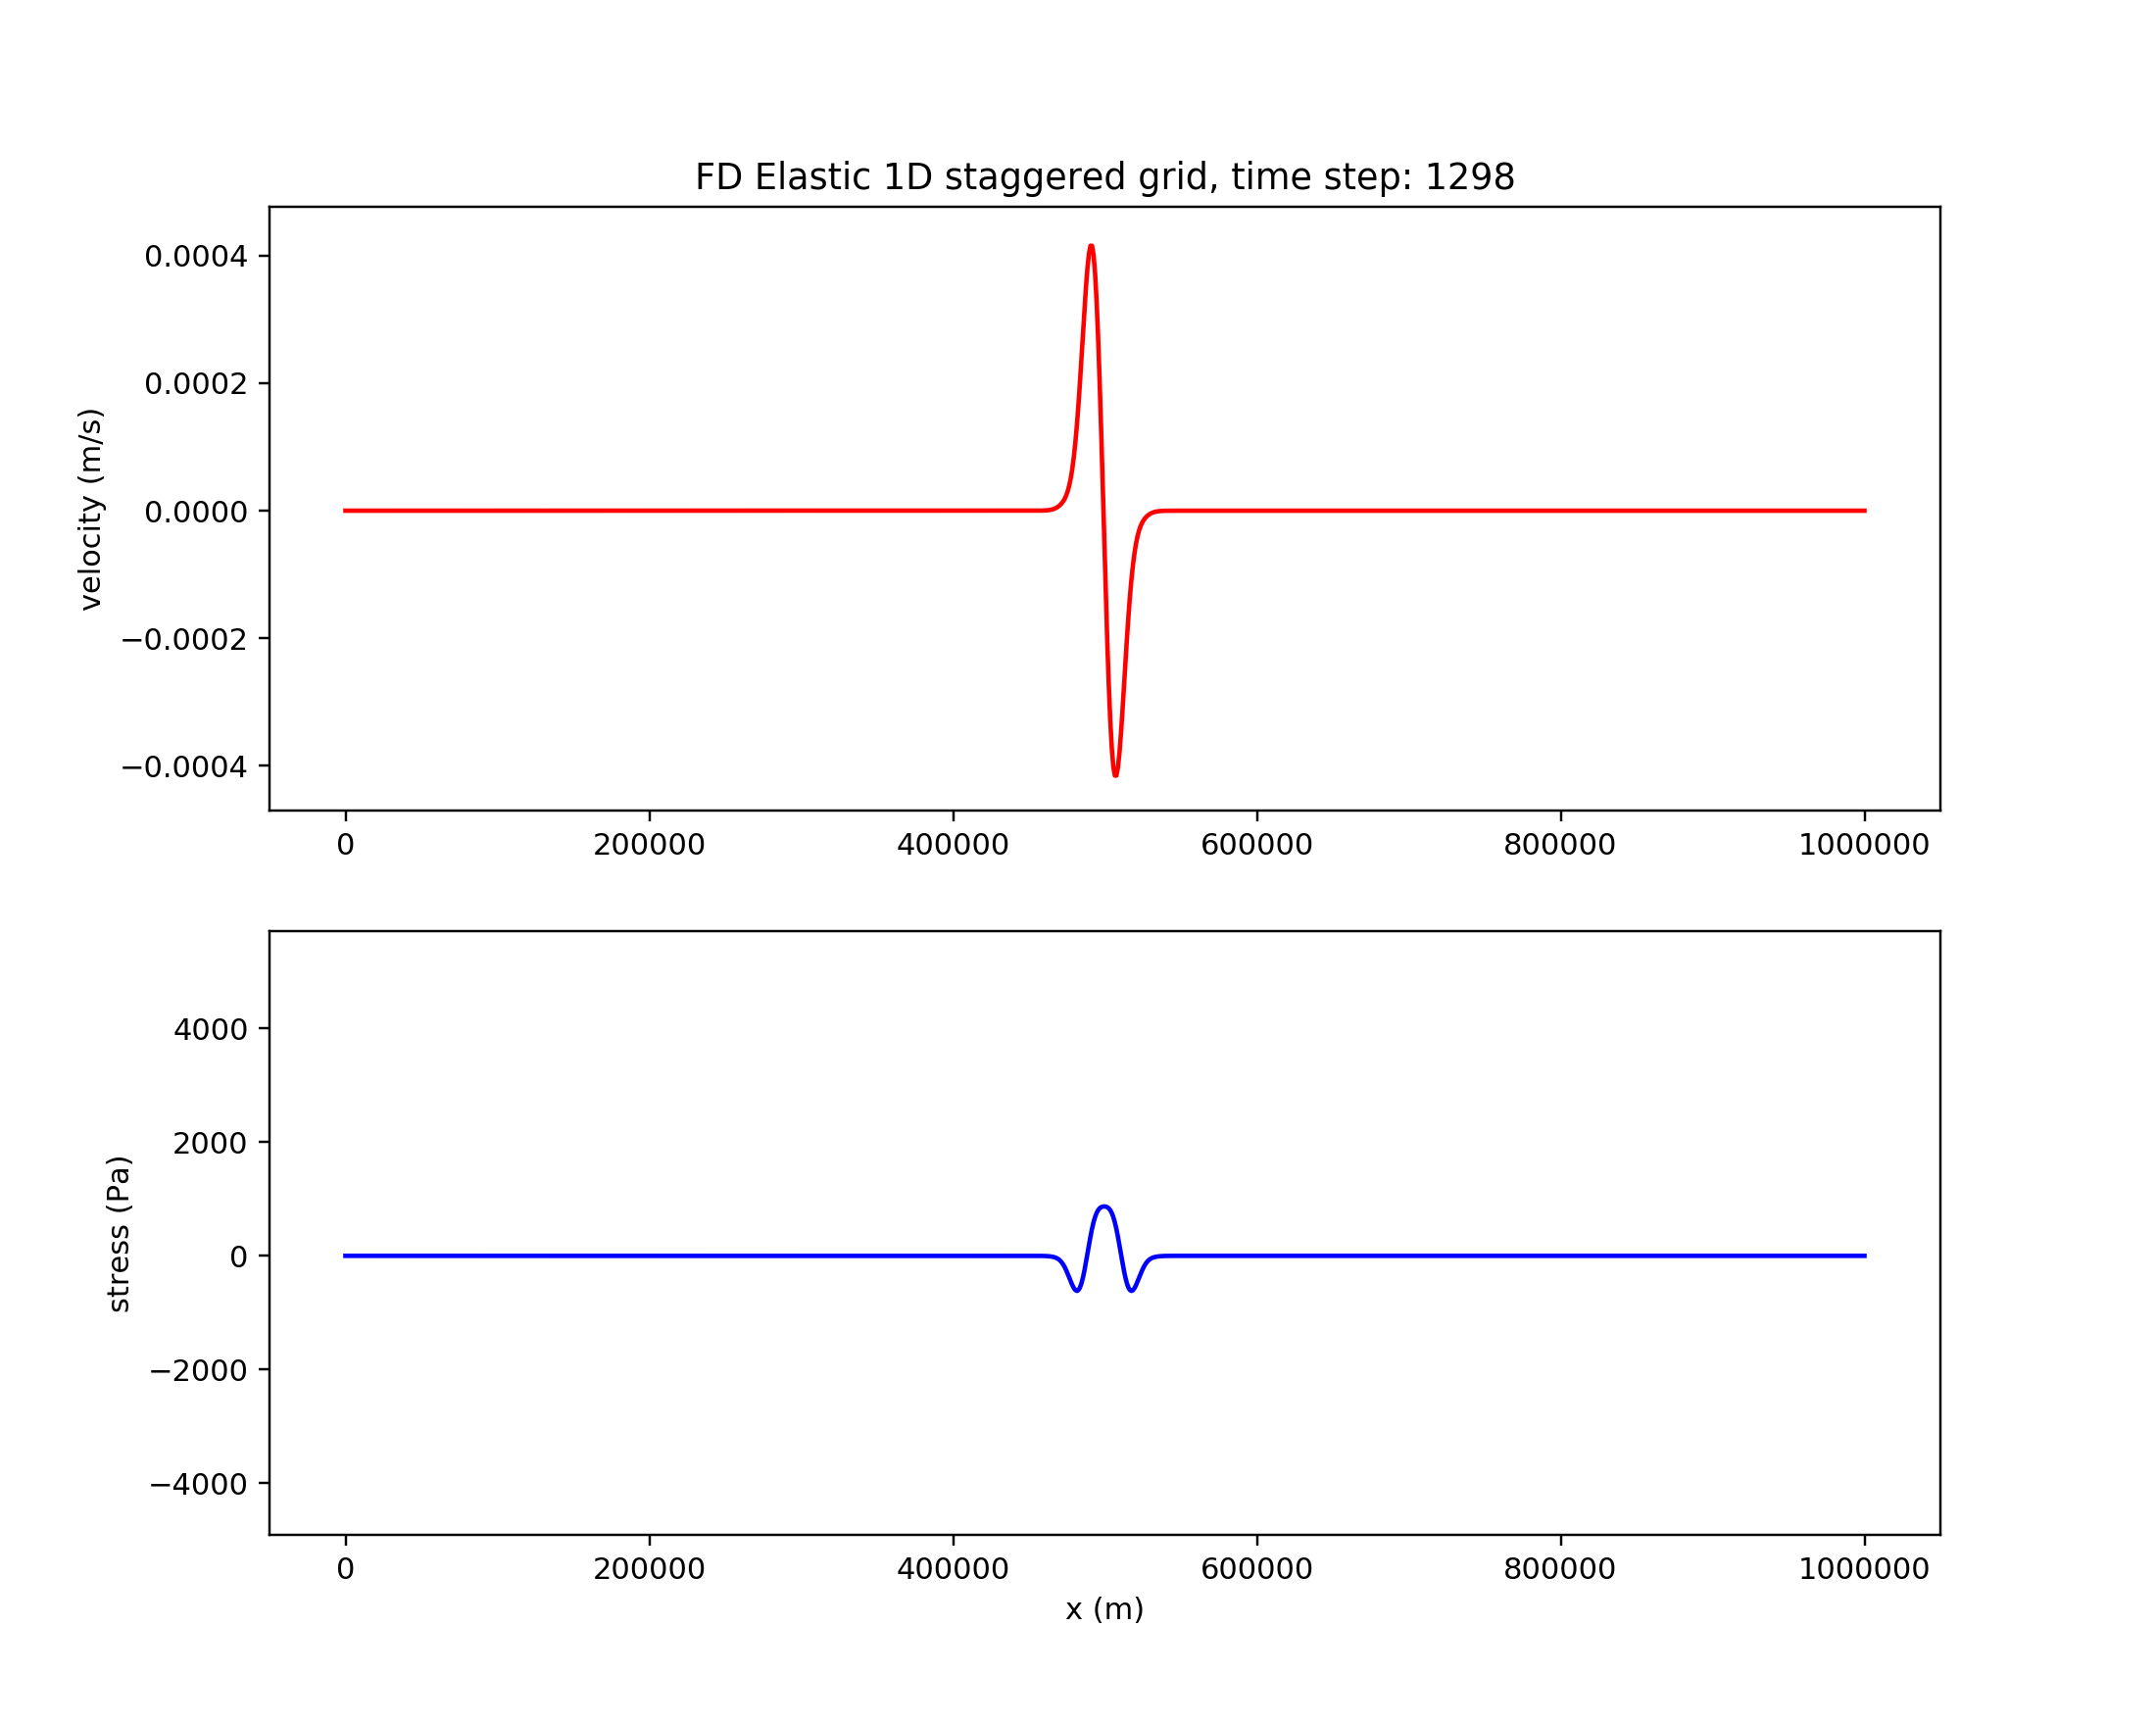

In [17]:
# Extrapolation scheme and the plots
# Initialization of plot

# Initialization of fields
v = np.zeros(nx)                                       # velocity
vnew = v
dv = v

s = np.zeros(nx)                                       # stress
snew = s
ds = s

mu = np.zeros(nx)                                      # shear modulus
rho = mu                                               
rho = rho + rho0
mu = mu + mu0

# Print setup parameters
print("rho =", rho0, ", f_dom =", f0, ", stability limit =", eps, ", n_lambda", (lam/dx))

# Initialize the plot
title = "FD Elastic 1D staggered grid"
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
line1 = ax1.plot(x, v, color = "red", lw = 1.5)
line2 = ax2.plot(x, s, color = "blue", lw = 1.5)
ax1.set_ylabel('velocity (m/s)')
ax2.set_xlabel('x (m)')
ax2.set_ylabel('stress (Pa)')
plt.ion()
plt.show()

In [18]:
# Begin extrapolation and update the plot
for it in range (nt):
    
    # Stress derivative
    for i in range (2, nx-2):
        ds[i] = (0.0416666 * s[i-1] - 1.125 * s[i] + 1.125 * s[i+1] - 0.0416666 * s[i+2]) / (dx)
    
    # Velocity extrapolation
    v = v + dt * ds / rho
    
    # Add source term at isx
    v[isx] = v[isx] + dt * src[it] / (dt * rho[isx])
    
    # Velocity derivative
    for i in range (2, nx-2):

        dv[i] = (0.0416666 * v[i-2] - 1.125 * v[i-1] + 1.125 * v[i] - 0.0416666 * v[i+1]) / (dx)
        
    # Stress extrapolation
    s = s + dt * mu * dv
    
    # Updating the plots
    if not it % isnap: 
        for l in line1:
            l.remove()
            del l               
        for l in line2:
            l.remove()
            del l 
        line1 = ax1.plot(x, v, color = "red", lw = 1.5)
        line2 = ax2.plot(x, s, color = "blue", lw = 1.5)
    
        ax1.set_title(title + ", time step: %i" % (it))  
        plt.gcf().canvas.draw()

plt.ioff()
plt.show()